In [1]:
import numpyro
import arviz as az
from numpyro.infer import MCMC, NUTS
from numpyro.infer import init_to_value, init_to_feasible
from matplotlib import pyplot as plt
from jax import random

from episuite import prevalence

# Set 2 cores in Numpyro
numpyro.set_host_device_count(2)

### True prevalence model
In this section we will estimate a true prevalence model, a model that assumes that you're observing true prevalences (i.e. on a seroprevalence study w/ perfect testing validation properties). Leter we will improve on it by assuming imperfect testing.

In [2]:
num_warmup, num_samples = 500, 2000

In [3]:
# Random generator needed by jax
rng_key = random.PRNGKey(42)
rng_key, rng_key_ = random.split(rng_key)

In [4]:
# Scenario: collected 4000 samples and 20 were found positive
total_observations = 4000
positive_observations = 20

In [5]:
# Configure MCMC with the true_prevalence_model from Episuite
kernel = NUTS(prevalence.true_prevalence_model, init_strategy=init_to_feasible())
mcmc = MCMC(kernel, num_warmup, num_samples, num_chains=1)

In [6]:
# Run MCMC
mcmc.run(rng_key_,
         obs_positive=positive_observations,
         obs_total=total_observations)

sample: 100%|██████████| 2500/2500 [00:06<00:00, 407.97it/s, 1 steps of size 1.12e+00. acc. prob=0.91]


In [7]:
samples = mcmc.get_samples()
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
    true_p      0.01      0.00      0.01      0.00      0.01    903.02      1.00

Number of divergences: 0


In [8]:
inference_data = az.from_numpyro(mcmc)

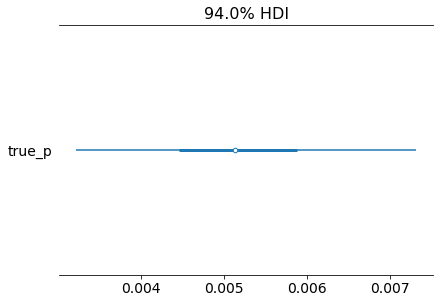

In [9]:
az.plot_forest(inference_data)
plt.show()

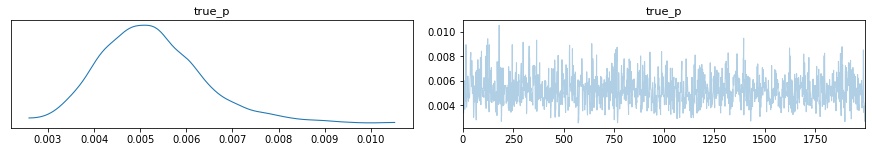

In [10]:
az.plot_trace(inference_data)
plt.show()

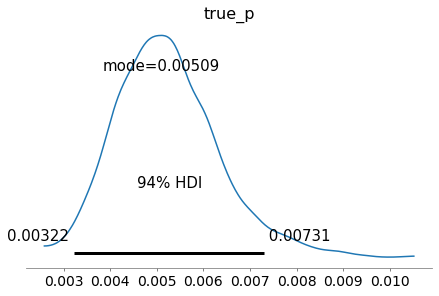

In [11]:
az.plot_posterior(inference_data, round_to=3, point_estimate="mode")
plt.show()

### Apparent prevalence model
In this section we will estimate an apparent prevalence model, a model that incorporates the sensitiviy and specificity properties of the test validation results. We will use here a scenario where we collected samples and tested for SARS-CoV-2 and assume properties from a real test from the brand Wondfo (used in Brazil on different seroprevalence surveys).

In [12]:
# Wondfo test parameters (taken from their product description from tests they made with a PCR gold standard)
#
# From a total of 42 confirmed COVID-19 positive patients: the test detected 42 positive and 0 negative.
# From a total of 172 COVID 19 negative patients: the test detected 2 positive and 170 negative.

# Specificity parameters
n_sp = 172
x_sp = 170

# Sensitivity paramters
n_se = 42
x_se = 42

# These are results from a seroprevalence study in Brazil 
observed_total = 4189
observed_positive = 2

In [13]:
kernel = NUTS(prevalence.apparent_prevalence_model,
              init_strategy=init_to_feasible())
mcmc = MCMC(kernel, num_warmup, num_samples, num_chains=1)

In [14]:
mcmc.run(rng_key_,
         x_se=x_se, n_se=n_se,           # Sensitivity parameters of the test used
         x_sp=x_sp, n_sp=n_sp,           # Specificity parameters of the test used
         obs_positive=observed_positive, # Positive results
         obs_total=observed_total)       # Total samples

sample: 100%|██████████| 2500/2500 [00:07<00:00, 352.70it/s, 7 steps of size 5.02e-01. acc. prob=0.91]


In [15]:
mcmc.print_summary(exclude_deterministic=False)
samples_1 = mcmc.get_samples()


                  mean       std    median      5.0%     95.0%     n_eff     r_hat
  apparent_p      0.00      0.00      0.00      0.00      0.00   1480.38      1.00
        se_p      0.98      0.02      0.98      0.95      1.00   1687.51      1.00
        sp_p      1.00      0.00      1.00      1.00      1.00   1247.72      1.00
      true_p      0.00      0.00      0.00      0.00      0.00   1587.27      1.00

Number of divergences: 0


In [16]:
inference_data = az.from_numpyro(mcmc)

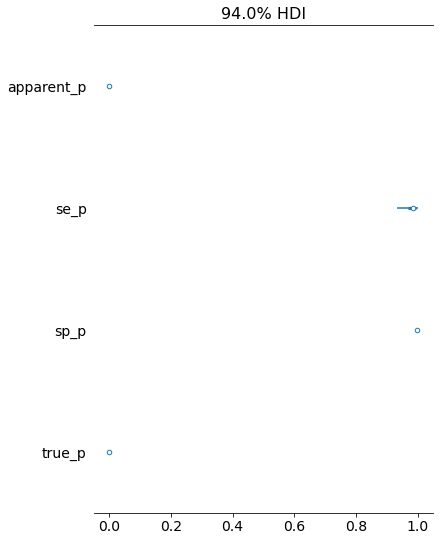

In [17]:
az.plot_forest(inference_data)
plt.show()

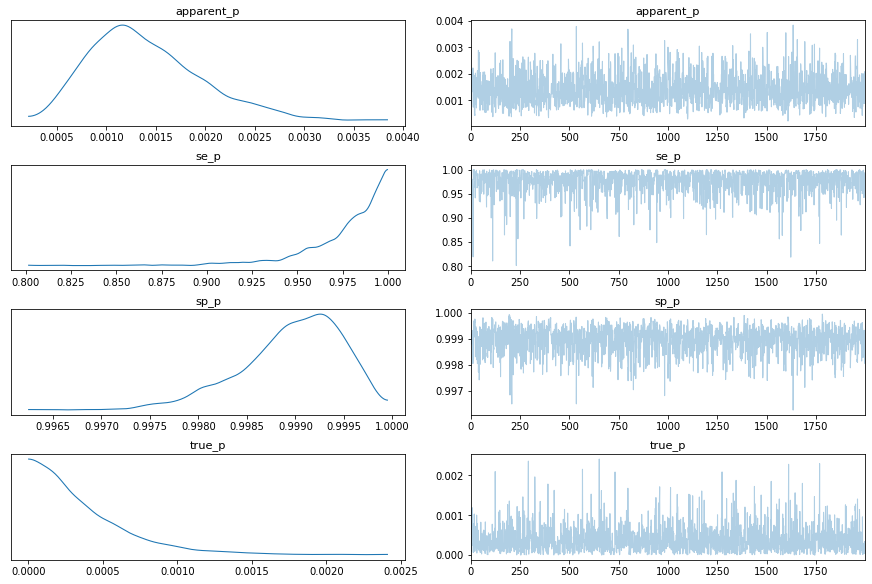

In [18]:
az.plot_trace(inference_data)
plt.show()

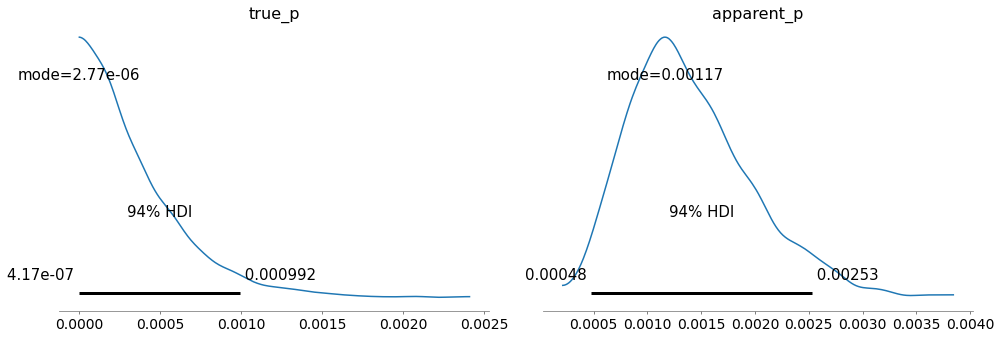

In [19]:
az.plot_posterior(inference_data, round_to=3,
                  point_estimate="mode", var_names=["true_p", "apparent_p"])
plt.show()

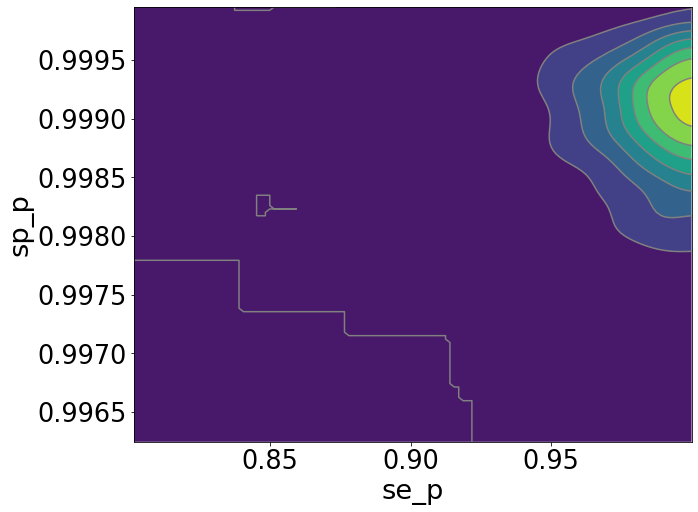

In [20]:
az.plot_pair(inference_data, var_names=["se_p", "sp_p"], kind="kde",
             colorbar=True, figsize=(10, 8), kde_kwargs={"fill_last": True})
plt.show()